<a href="https://colab.research.google.com/github/s4kh4rov/BMIL/blob/master/lab2rpsmo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets
!pip install pandas

In [14]:
import opendatasets as od
import pandas
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dropout , BatchNormalization
import pandas as pd


In [4]:
od.download("https://www.kaggle.com/datasets/ashishmotwani/tomato/data?select=train")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: alexsakharov
Your Kaggle Key: ··········


100%|██████████| 1.37G/1.37G [00:27<00:00, 53.8MB/s]


In [51]:
from pathlib import Path
import imghdr
import os

# data_dir = "/content/tomato/train/Early_blight/"
# data_dir = "/content/tomato/train/Leaf_Mold/"
# data_dir = "/content/tomato/train/Septoria_leaf_spot/"
# data_dir = "/content/tomato/train/healthy/"
# data_dir = "/content/tomato/valid/Septoria_leaf_spot/"
# data_dir = "/content/tomato/valid/healthy/"
image_extensions = [".png", ".jpg"]

img_type_accepted_by_tf = ["bmp", "gif", "jpeg", "png"]
for filepath in Path(data_dir).rglob("*"):
    if filepath.suffix.lower() in image_extensions:
        img_type = imghdr.what(filepath)
        if img_type is None:
            print(f"{filepath} is not an image")
            os.remove(filepath)
        elif img_type not in img_type_accepted_by_tf:
            print(f"{filepath} is a {img_type}, not accepted by TensorFlow")
            os.remove(filepath)

In [63]:
train_datadir = '/content/tomato/train/'
valid_datadir = '/content/tomato/valid/'
# IMG_SIZE = 224
IMG_SIZE = 64

train_ds = tf.keras.utils.image_dataset_from_directory(
  train_datadir,
  # subset="training",
  # validation_split = 0.7,
  color_mode='rgb',
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=15)

val_ds = tf.keras.utils.image_dataset_from_directory(
  valid_datadir,
  validation_split=0.3,
  subset="validation",
  color_mode='rgb',
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=15)

test_ds = tf.keras.utils.image_dataset_from_directory(
  valid_datadir,
  validation_split=0.3,
  subset="training",
  color_mode='rgb',
  seed=123,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=15)

Found 25838 files belonging to 11 classes.
Found 6678 files belonging to 11 classes.
Using 2003 files for validation.
Found 6678 files belonging to 11 classes.
Using 4675 files for training.


In [64]:
class_names = test_ds.class_names
class_names

['Bacterial_spot',
 'Early_blight',
 'Late_blight',
 'Leaf_Mold',
 'Septoria_leaf_spot',
 'Spider_mites Two-spotted_spider_mite',
 'Target_Spot',
 'Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato_mosaic_virus',
 'healthy',
 'powdery_mildew']

In [65]:
classifier = Sequential()
classifier.add(Rescaling(1./255, input_shape=(IMG_SIZE, IMG_SIZE, 3))),
classifier.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same', strides=1))
classifier.add(MaxPooling2D(pool_size=(2,2), padding='valid', strides=2))
classifier.add(Conv2D(filters=32, kernel_size=3,activation='relu', padding='same', strides=1))
classifier.add(MaxPooling2D(pool_size=(2,2), padding='valid', strides=2))
classifier.add(Flatten())
classifier.add(Dense(units=128, activation='relu'))
classifier.add(Dense(units=11, activation='softmax'))
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
classifier.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_14 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 32, 32, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 16, 16, 32)        0         
 ng2D)                                                           
                                                                 
 flatten_7 (Flatten)         (None, 8192)             

In [67]:
callbacks = [EarlyStopping(monitor='val_loss',min_delta=0.01,
                           patience=2),
             ModelCheckpoint('/content/drive/MyDrive/rpsmo_lab2_model/tomato_model_checkpoint.keras',
                             save_best_only=True)]

In [68]:
history = classifier.fit(train_ds, epochs=50,
                        validation_data = val_ds,
                        callbacks = callbacks)

Epoch 1/50
1723/1723 [==============================] - 211s 92ms/step - loss: 1.1285 - accuracy: 0.6094 - val_loss: 0.7022 - val_accuracy: 0.7579
Epoch 2/50
1723/1723 [==============================] - 160s 93ms/step - loss: 0.6106 - accuracy: 0.7881 - val_loss: 0.5452 - val_accuracy: 0.8163
Epoch 3/50
1723/1723 [==============================] - 157s 91ms/step - loss: 0.4502 - accuracy: 0.8457 - val_loss: 0.4926 - val_accuracy: 0.8347
Epoch 4/50
1723/1723 [==============================] - 163s 94ms/step - loss: 0.3241 - accuracy: 0.8892 - val_loss: 0.5699 - val_accuracy: 0.8303
Epoch 5/50
1723/1723 [==============================] - 155s 90ms/step - loss: 0.2448 - accuracy: 0.9135 - val_loss: 0.6383 - val_accuracy: 0.8347


In [69]:
classifier.save('/content/drive/MyDrive/rpsmo_lab2_models/romato_1_model.keras')

<Axes: >

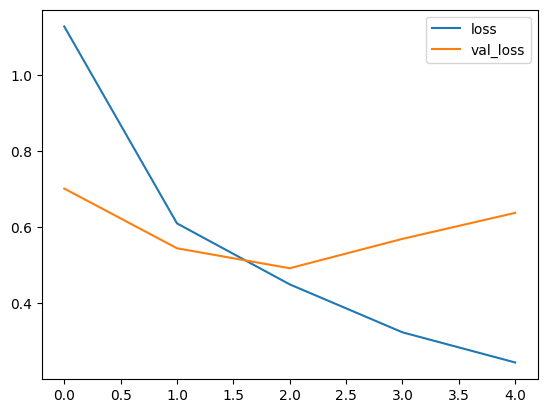

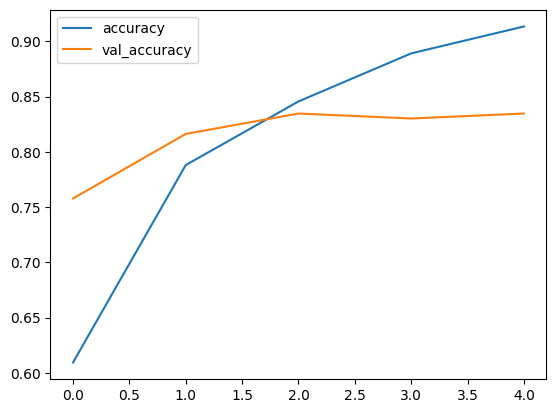

In [70]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:,['loss','val_loss']].plot()
history_frame.loc[:,['accuracy','val_accuracy']].plot()

In [71]:
result_test = classifier.evaluate(test_ds)

312/312 [==============================] - 14s 45ms/step - loss: 0.6322 - accuracy: 0.8295
